In [1]:
from src import *
import json

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

## Table of Contents
- [Emotion item data](#emotion)
    - Reformatting
    - Exploring
- [fMRI data](#fmri)
    - Reformatting
    - Exploring

<a class="anchor" id="emotion"></a>
### Emotion item data

In [2]:
emo_path = "./data/emoFiles/emo/"
# emo_path = "./data/emoFiles/EmoBIDS/"

We simplify the datasets so to make it easier in the future to load. Be careful that the formats for any of our processed emotion csv would be the following way.

#### Reformatting

We reformat "Emo" folder's file that we first started with. (with z-scored emotion series)

In [6]:
# We load the emotions' index in the other file
df     = pd.read_csv(emo_path + '/W_labels.csv', sep='\t')
labels = list(df.columns) + list(df.iloc[:,0])
labels = {idx:emotion for idx, emotion in enumerate(labels)}

# We load the scores for each movies
record = {'filename': [], 'item': [], 'score': []}
for filename in tqdm(os.listdir(emo_path)):
    if 'labels' in filename: continue
    df           = pd.read_csv(emo_path + '/' + filename, sep='\t')
    double_array = np.concatenate((np.array(df.columns).astype(float)[None],np.array(df)))
    nbt, nbitem  = double_array.shape
    
    for item_idx in range(nbitem):
        record['score'] += list(double_array[:,item_idx])
        record['item'] += ([labels[item_idx]] * nbt)

    record['filename'] += ([filename] * nbt * nbitem)


emo_df = pd.DataFrame.from_dict(record)
# #Uncomment to save the record to csv
# emo_df.to_csv('./data/emotion_compile.csv', index=False)

100%|██████████| 15/15 [00:00<00:00, 121.98it/s]


We reformat "Emo_BIDS" folder's file that we later got, the emotion timeseries are comparable across emotions and movies.

In [7]:
movienames = list(FILM2DURATION.keys())

record = {'filename': [], 'item': [], 'score': []}
for e in movienames:
    # Wrote this quick fix because of mismatch between files for the name "BetweenViewing"/(s)
    if e == 'BetweenViewing':
        e = 'BetweenViewings'

    filenamejson = 'W_Annot_13_{}_stim.json'.format(e)
    filenametsv  = 'W_Annot_13_{}_stim.tsv'.format(e)
    
    # We load the emotions' index in the other file
    with open('./data/emoFiles/EmoBIDS/{}'.format(filenamejson)) as f:
        tmp = json.load(f)
    
    # We load the scores for each movies
    double_array = np.loadtxt('./data/emoFiles/EmoBIDS/{}'.format(filenametsv), delimiter='\t')
    nbt, nbitem  = double_array.shape
    
    for item_idx in range(nbitem):
        record['score'] += list(double_array[:,item_idx])
        record['item']  += ([tmp['Columns'][item_idx]] * nbt)    
        
    record['filename'] += (['W_{}13.csv'.format(e)] * nbt * nbitem)

emo_df2 = pd.DataFrame.from_dict(record)
# #Uncomment to save the record to csv
# emo_df2.to_csv('./data/emotion_compileBIDS.csv', index=False)

#### Exploring

In the long run we need to understand in a movie:
- where events are
- which feeling is happening the most often in general we don't have absolute values so timesereis from metrics should be discrete differences as well 
- how long an event is happening for us to be able to catch it in terms of change 

We partially look into it in the following plots.

1. We look in this case how present each emotions are in a movie. We compute the average score it receives during the movie and compare it with the other emotions.

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


categories = np.array(['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad'])

fig = make_subplots(rows=2, cols=3)
partial_mov = emo_df2.filename.unique()
dispersion = {}
for idx,mov in enumerate(partial_mov):
    row,col = idx//3, idx%3
    r1 = []
    for s in categories:
      tmp = np.array(list(emo_df2[(emo_df2.filename == mov) & (emo_df2.item == s)]['score']))
      r1.append(tmp.mean())

    dispersion[mov] = r1
    fig.add_trace(go.Scatterpolar(
          r=r1,
          theta=categories,
          fill='toself',
          name=mov.split('_')[1] + 'Mean'          
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      # range=[0, 5]
    )),
  showlegend=True
)

fig.show()

2. Let's look what emotion is dominant and what proportion it takes?
We might need this information when looking at the gradients for specific SINGLE emotions

In [14]:
props = []
for idx,mov in enumerate(partial_mov):
    tmp = np.array(dispersion[mov])
    tmp -= tmp.min()
    prop = tmp/tmp.sum()
    props.append(prop)
props = np.asarray(props)

Main emotion and proportion the most often emotion takes in terms of explaining the variance of emotion series {} 

In [20]:
{mov:[categories[props.argmax(axis=1)][idx], np.round(props.max(axis=1)[idx], 3)] for idx,mov in enumerate(partial_mov)}

{'W_AfterTheRain13.csv': ['Fear', 0.148],
 'W_BetweenViewings13.csv': ['WarmHeartedness', 0.172],
 'W_BigBuckBunny13.csv': ['Disgust', 0.234],
 'W_Chatter13.csv': ['Fear', 0.261],
 'W_FirstBite13.csv': ['Love', 0.201],
 'W_LessonLearned13.csv': ['Disgust', 0.203],
 'W_Payload13.csv': ['Disgust', 0.163],
 'W_Sintel13.csv': ['Anger', 0.241],
 'W_Spaceman13.csv': ['WarmHeartedness', 0.197],
 'W_Superhero13.csv': ['Fear', 0.16],
 'W_TearsOfSteel13.csv': ['Anxiety', 0.154],
 'W_TheSecretNumber13.csv': ['Fear', 0.142],
 'W_ToClaireFromSonny13.csv': ['Happiness', 0.141],
 'W_YouAgain13.csv': ['Guilt', 0.134]}

3. Let's as well visualize the timeseries for few items in a movie

Text(0.5, 1.0, 'Scores over time for W_Chatter13.csv')

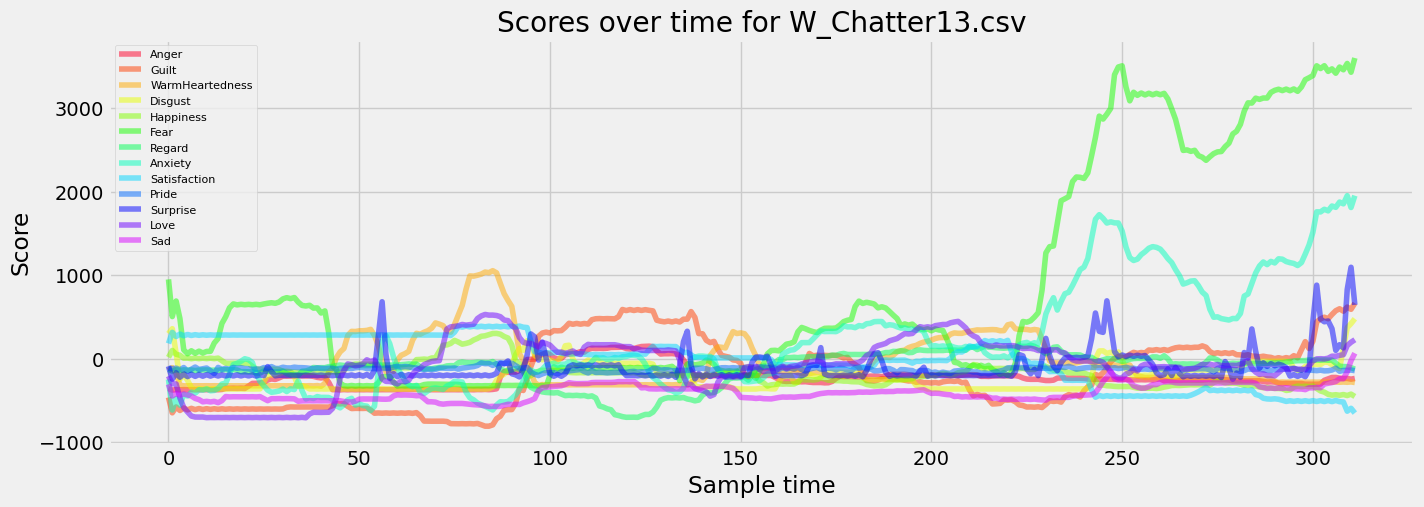

In [13]:
# NOTE: that the temporal coherence was kept when we reformatted the files
moviename = 'W_Chatter13.csv'

select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']

NUM_COLORS = len(select)
cm = plt.get_cmap('gist_rainbow')
fig,ax = plt.subplots(1,1, figsize=(15,5))
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for s in select:
        cur_df = emo_df2[(emo_df2['filename'] == moviename) & 
                (emo_df2['item'] == s)]
        ax.plot(np.arange(len(cur_df)), cur_df['score'], label=s, alpha=0.5)
ax.legend(prop={'size':8})
ax.set_xlabel('Sample time')
ax.set_ylabel('Score')
ax.set_title('Scores over time for {}'.format(moviename))

4. We look into as well correlation across movies for the same emotion

It is as well interesting as we use as a null distribution for verifying the significancy of emotion series VS metric series, all movies except the current one. And so it correlation happens between emotions then we would as well expect few high values in the null distribution.

In [22]:
movienames = emo_df2.filename.unique()
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']
n    = len(movienames)          
w2 = {}   
for item in tqdm(select):
    corr_mat   = np.zeros((n,n))

    for midx, m in enumerate(movienames):
        for nidx, k in enumerate(movienames):
            tmp1 = np.array(list(emo_df2[(emo_df2.filename == m) & (emo_df2.item == item)]['score']))
            tmp2 = np.array(list(emo_df2[(emo_df2.filename == k) & (emo_df2.item == item)]['score']))
            M = min(tmp1.shape[0], tmp2.shape[0])
            corr_mat[midx,nidx] = stats.pearsonr(tmp1[:M], tmp2[:M]).statistic
    tmpmat = (corr_mat - np.eye(corr_mat.shape[0]))
    w2[item] = tmpmat.max(), np.argmax(tmpmat)

100%|██████████| 13/13 [02:55<00:00, 13.54s/it]


In [35]:
w3 = {}
for e in w2.keys():
    t1,t2 = w2[e]
    a,b   = t2//14, 52%14
    w3[e] = (np.round(t1,3), (movienames[a].split('_')[1].strip('13.csv'),movienames[b].split('_')[1].strip('13.csv'))) 

In [36]:
w3

{'Anger': (0.766, ('BigBuckBunny', 'TearsOfSteel')),
 'Guilt': (0.726, ('BetweenViewing', 'TearsOfSteel')),
 'WarmHeartedness': (0.683, ('Spaceman', 'TearsOfSteel')),
 'Disgust': (0.886, ('BigBuckBunny', 'TearsOfSteel')),
 'Happiness': (0.787, ('ToClaireFromSonny', 'TearsOfSteel')),
 'Fear': (0.754, ('Chatter', 'TearsOfSteel')),
 'Regard': (0.704, ('Spaceman', 'TearsOfSteel')),
 'Anxiety': (0.816, ('Chatter', 'TearsOfSteel')),
 'Satisfaction': (0.786, ('ToClaireFromSonny', 'TearsOfSteel')),
 'Pride': (0.661, ('BigBuckBunny', 'TearsOfSteel')),
 'Surprise': (0.536, ('TheSecretNumber', 'TearsOfSteel')),
 'Love': (0.792, ('LessonLearned', 'TearsOfSteel')),
 'Sad': (0.84, ('AfterTheRain', 'TearsOfSteel'))}

5. Example of what a correlated two emotion series looks like

In [37]:
tmp1 = np.array(list(emo_df2[(emo_df2.filename == "W_Chatter13.csv") & (emo_df2.item == "Anxiety")]['score']))
tmp2 = np.array(list(emo_df2[(emo_df2.filename == "W_TearsOfSteel13.csv") & (emo_df2.item == "Anxiety")]['score']))

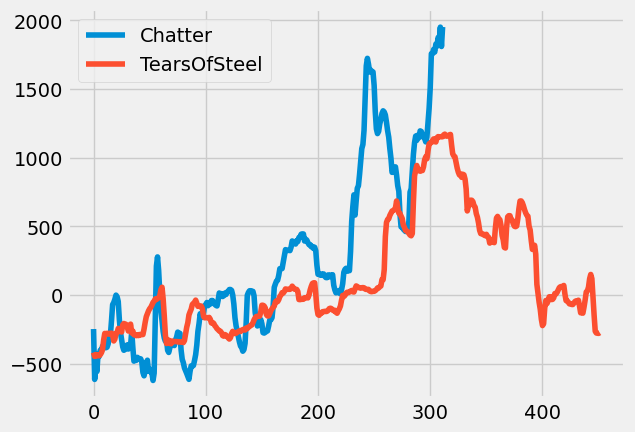

In [41]:
plt.plot(tmp1, label='Chatter')
plt.plot(tmp2, label='TearsOfSteel')
plt.legend()

<a class="anchor" id="fmri"></a>
### fMRI data

In [4]:
mri_path = "./data/fMRIFiles/TRFiles/"

#### Reformatting

In [78]:
labels = pd.read_csv('./data/labels/7N_networks_centroids.csv')

In [79]:
files = os.listdir(mri_path)
names = set([f.split('_')[4] for f in files])
names = [n.strip('.csv') for n in names]

1. Cortical Only

We first split up with cortical only timecourses (since we may need to process only cortical parcels, so excluding subcortical)

In [82]:
for idx in tqdm(range(len(names))):
    files_specific = [f for f in files if names[idx] in f]

    # we keep a dictionary with each film and their respective scores for each item in a double array
    record = {'filename': [], 'vindex': [],'full_region': [], 
                'partial_region': [],'score': [], 'movie_name':[], 'parcel': []
                ,'id': [], 'session': []}
    for filename in tqdm(files_specific):
        _, parcel, _id, session, moviename = filename.split('_')
        moviename    = moviename.strip('.csv')
        # df           = pd.read_csv(mri_path + '/' + filename)
        # double_array = np.concatenate((np.array(df.columns).astype(float)[None],np.array(df)))
        
        double_array = np.loadtxt(mri_path + '/' + filename, delimiter=',')
        nbt, nbvoxel = double_array.shape
        
        for voxel_idx in range(nbvoxel):
            record['score'] += list(double_array[:,voxel_idx])
            record['vindex'] += [voxel_idx] * nbt
            
            region_name  = labels[labels['ROI Label'] == voxel_idx + 1]['ROI Name'].item()
            # partial_name = '_'.join(region_name.split('_')[1:-1])
            partial_name = region_name.split('_')[2]
            record['full_region']    += ([region_name] * nbt)
            record['partial_region'] += ([partial_name] * nbt)


        record['filename']   += ([filename] * nbt * nbvoxel)
        record['movie_name'] += ([moviename] * nbt * nbvoxel)
        record['parcel']     += ([parcel] * nbt * nbvoxel)
        record['id']         += ([_id] * nbt * nbvoxel)
        record['session']    += ([session] * nbt * nbvoxel)

    mri_df = pd.DataFrame.from_dict(record)

    # #Uncomment to save the record to csv
    mri_df.to_csv('./data/fmri400_compiled/'+names[idx]+'_compiled.csv', index=False)

100%|██████████| 15/15 [12:28<00:00, 49.91s/it]


2. Combine Subcortical and Cortical

We pick up the compiled versions with only Cortical and generate a compiled version with subcortical areas included as well

In [88]:
with open('./data/labels/TC_sub14_labels.csv') as f:
    text = f.readlines()
    text = [t.strip() for t in text]

In [89]:
compiled_list = os.listdir('./data/fmri400_compiled/')

for cfile in tqdm(compiled_list):
    mri_df = pd.read_csv('./data/fmri400_compiled/{}'.format(cfile))

    subcort = mri_df[mri_df.parcel == 14]
    tmp_df  = mri_df.drop(subcort.index)

    # We reset the index the regions, adding the 14 subcortical regions to the 400 parcellations
    # And we then call the subcortical area to be the "Sub" network
    subcort['full_region'] = np.array(text)[np.array(subcort.vindex)]
    subcort['vindex'] = 400 + subcort['vindex'] 
    subcort['partial_region'] = 'Sub'

    res_df = pd.concat([tmp_df,subcort])

    rename = lambda x: 'TC_414_'+'_'.join(np.array(x.split('_'))[[2,4]])
    res_df['filename'] = res_df['filename'].apply(rename)

    res_df.to_csv('./data/fmri414_compiled/{}414.csv'.format(cfile[:-4]), index=False)

/var/folders/95/vrc1ltz17tn5l8mk269kgjc80000gn/T/ipykernel_37347/1673759976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subcort['full_region'] = np.array(text)[np.array(subcort.vindex)]
/var/folders/95/vrc1ltz17tn5l8mk269kgjc80000gn/T/ipykernel_37347/1673759976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subcort['vindex'] = 400 + subcort['vindex']
/var/folders/95/vrc1ltz17tn5l8mk269kgjc80000gn/T/ipykernel_37347/1673759976.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [90]:
# verify correct formatting by comparing the timecourse loading I implemented versus direct load from original file
# we load a random file and check that indeed the timecourses were kept almost the same (up to very very small change in float value)
tmp = np.loadtxt("./data/fMRIFiles/TRFiles/TC_400_sub-S22_ses-1_TheSecretNumber.csv", delimiter=',')

movie_name414   = 'TheSecretNumber_compiled414.csv'
mri_df414mov    = pd.read_csv('./data/fmri414_compiled/' + movie_name414)

movie_series414, _ = df_to_timeseries(mri_df414mov, "TC_414_sub-S22_TheSecretNumber.csv")

tmp[np.isnan(tmp)] = 0
movie_series414[np.isnan(movie_series414)] = 0

np.sum(movie_series414[:,:400] - tmp)

3. Exploring

Plot a few timeseries for some arbitrary voxels

In [7]:
mri_df = pd.read_csv('./data/fmri400_compiled/Rest_compiled.csv')

Text(0, 0.5, 'Bold')

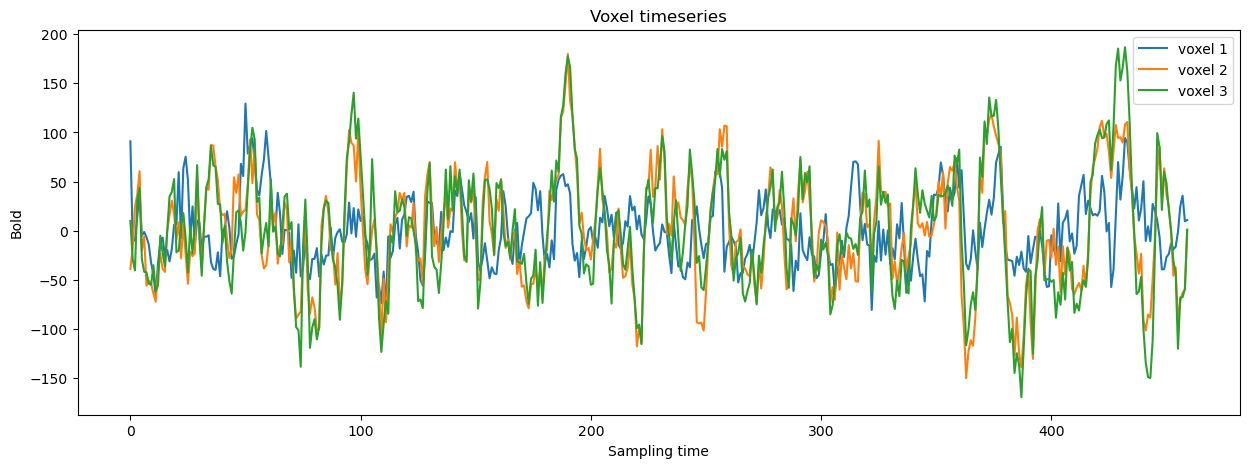

In [12]:
filename = 'TC_400_sub-S09_ses-1_Rest.csv'
tmp,cur  = df_to_timeseries(mri_df, filename)

plt.figure(figsize=(15,5))
plt.plot(tmp[:,0], label='voxel 1')
plt.plot(tmp[:,10], label='voxel 2')
plt.plot(tmp[:,20], label='voxel 3')
plt.legend()
plt.title('Voxel timeseries')
plt.xlabel('Sampling time')
plt.ylabel('Bold')

In [107]:
from scipy.ndimage import gaussian_filter

sigma = 50
cutoff_freq = 1/(2*TR*sigma)
newsigma = 2
newcutoff_freq = 1/(2*TR*newsigma)
# sig_gauss = 1/np.sqrt(8*np.log(2)) * 1/(TR*cutoff_freq)

In [108]:
newcutoff_freq

0.1923076923076923

In [103]:
cutoff_freq

0.007692307692307693

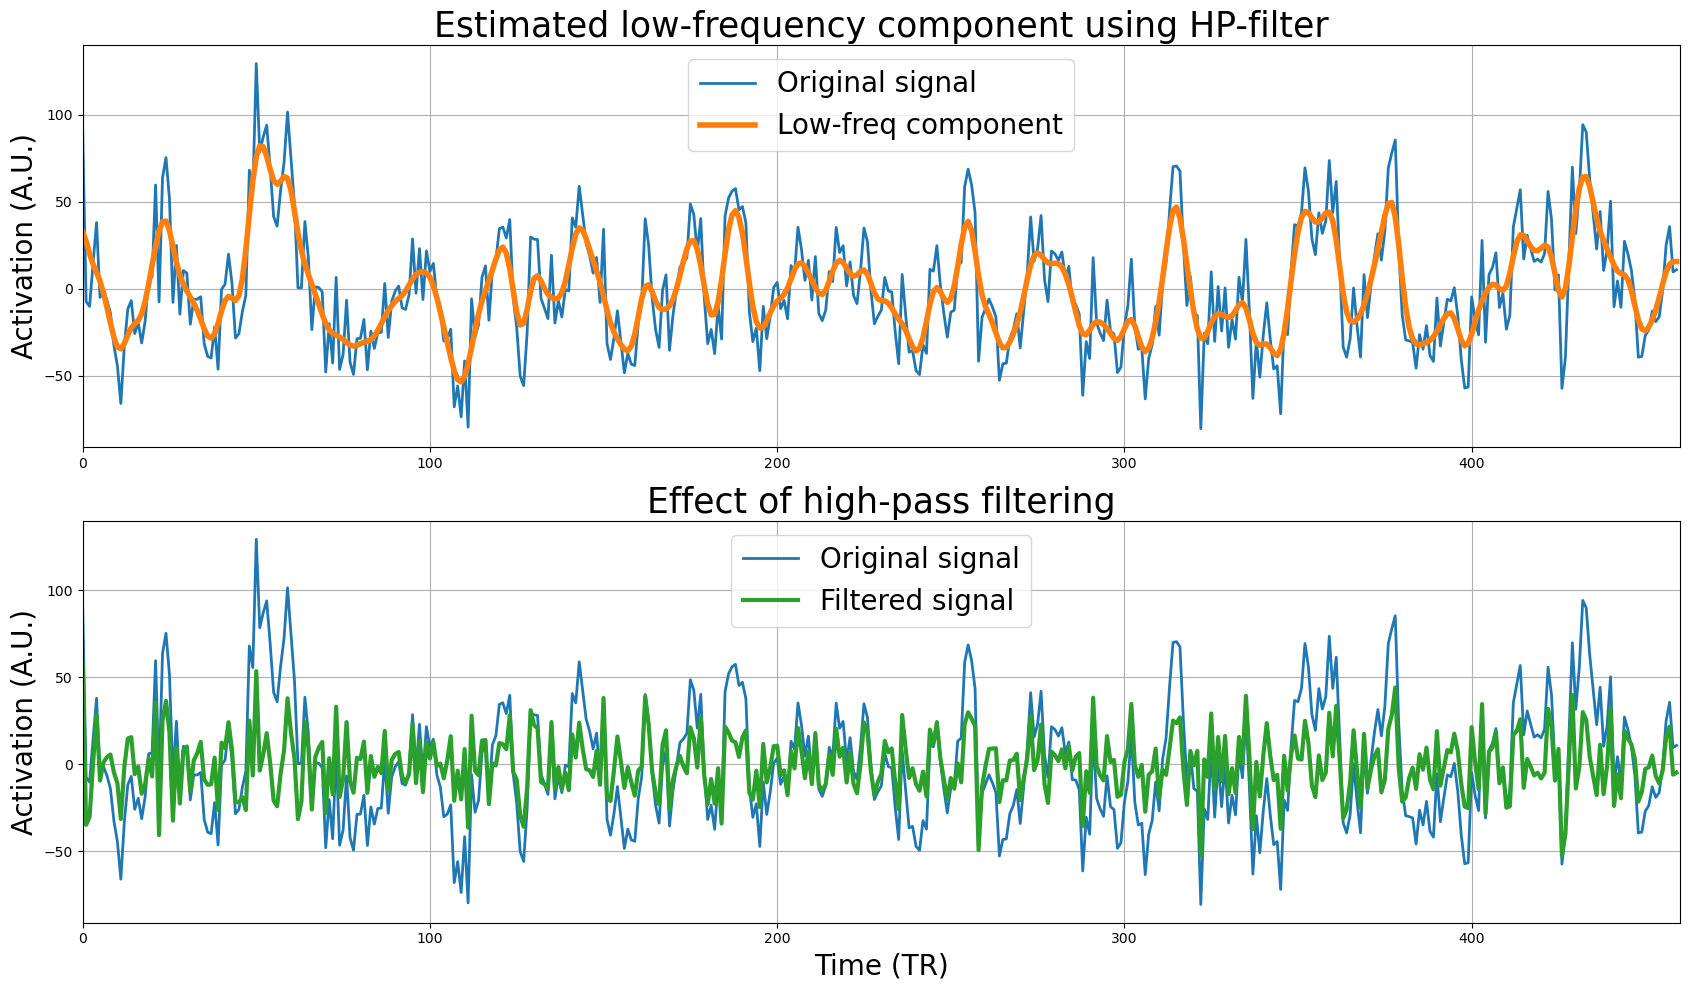

In [109]:
# https://lukas-snoek.com/NI-edu/fMRI-introduction/week_4/temporal_preprocessing.html
sig = tmp[:,0]
filt = gaussian_filter(sig, newsigma)

plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
plt.plot(sig, lw=2)
plt.plot(filt, lw=4)
plt.xlim(0, sig.size)
plt.legend(['Original signal', 'Low-freq component'], fontsize=20)
plt.title("Estimated low-frequency component using HP-filter", fontsize=25)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()

# IMPORTANT: subtract filter from signal
filt_sig = sig - filt

plt.subplot(2, 1, 2)
plt.plot(sig, lw=2)
plt.plot(filt_sig, lw=3, c='tab:green')
plt.xlim(0, sig.size)
plt.legend(['Original signal', 'Filtered signal'], fontsize=20)
plt.title("Effect of high-pass filtering", fontsize=25)
plt.xlabel("Time (TR)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

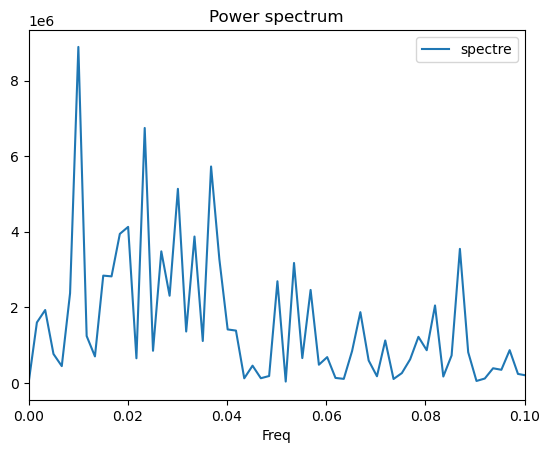

In [110]:
plot_spectrum(tmp[:,0], ls=0, rs=0.1)

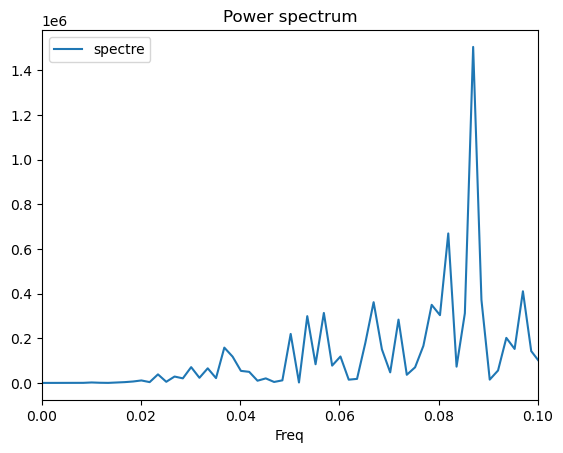

In [111]:
plot_spectrum(filt_sig, ls=0, rs=0.1)

In [24]:
from scipy.signal import butter, lfilter, filtfilt, freqz,welch


# https://github.com/phuselab/pyVHR/blob/758364e92dab384fe49be975eba380d157da21a7/pyVHR
def BPfilter(x, minHz, maxHz, fs, order=6):
    """
    desc: filtering out frequency that is in the desired interval
    
    args: 
        - x::[array<float>]
            signal
        - minHz::[float]
        - maxHz::[float]
        - fs::[int]
            sampling rate
    ret:  
    
    """
    """Band Pass filter (using BPM band)"""

    #nyq = fs * 0.5
    #low = minHz/nyq
    #high = maxHz/nyq

    #print(low, high)
    b, a = butter(order, Wn=[minHz, maxHz], fs=fs, btype='bandpass')
    #y = lfilter(b, a, x)
    y = filtfilt(b, a, x)

    return y

import scipy.fftpack as fftpack
# Temporal bandpass filter with Fast-Fourier Transform
def fft_filter(video, freq_min, freq_max, fps):
    	
    fft = fftpack.fft(video, axis=0)
    frequencies = fftpack.fftfreq(video.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - freq_min)).argmin()
    bound_high = (np.abs(frequencies - freq_max)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0
    iff = fftpack.ifft(fft, axis=0)
    result = np.abs(iff)
    result *= 100  # Amplification factor

    return result, fft, frequencies